In [1]:
"""
Time: 2022/7/29 11:42 BJT +8
Name: 林子皓
Project: ModelArts Iris Classification
Versions: 1.18
"""
import os
# os.environ['DEVICE_ID'] = '20214001060'
import csv
import numpy as np
import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore.common.api import ms_function
from mindspore.ops import operations as P
from matplotlib import pyplot as plt

context.set_context(mode=context.GRAPH_MODE,device_target="CPU")


In [2]:
# read File
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file))
print(data[0:5])
print(data[50:55])
# print some samples to check whether file is successfully loaded

[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'], ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa'], ['4.7', '3.2', '1.3', '0.2', 'Iris-setosa'], ['4.6', '3.1', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.6', '1.4', '0.2', 'Iris-setosa']]
[['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor']]


In [3]:
# get some examples for X and Y
labels = {'Iris-setosa': 0, 'Iris-versicolor': 1}
X = np.array([[float(x) for x in s[:-1]] for s in data[:100]], np.float32)
Y = np.array([labels[s[-1]] for s in data[:100]], np.float32)


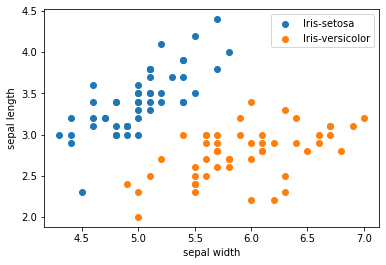

In [4]:
# Sample Visualization
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], label='Iris-versicolor')
plt.xlabel('sepal width')
plt.ylabel('sepal length')
plt.legend()

[WARNING] DEBUG(13746,python):2022-07-30-11:33:21.209.677 [mindspore/ccsrc/debug/debugger/debugger.cc:80] Debugger] Not enabling debugger. Debugger does not support CPU.


Text(0, 0.5, 'p')

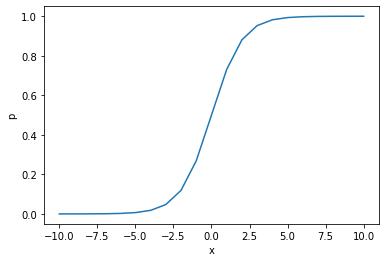

In [5]:
# Split sample for training and testing
iris_train_index = np.random.choice(100, 80, replace=False)
iris_test_index = np.array(list(set(range(100)) - set(iris_train_index)))
X_train, Y_train = X[iris_train_index], Y[iris_train_index]
X_test, Y_test = X[iris_test_index], Y[iris_test_index]

# Use GeneratorDataset transform numpy.ndarray into Dataset
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y']) # source, column_names
ds_train = ds_train.shuffle(buffer_size=80).batch(32, drop_remainder=True)

# Visualize Logic Regress Function
sig_x = np.arange(-10, 11, dtype=np.float32)
sig_y = nn.Sigmoid()(ms.Tensor(sig_x)).asnumpy()
plt.plot(sig_x,sig_y)
plt.xlabel('x')
plt.ylabel('p')

In [6]:
# Customize Loss Function
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.sigmoid_cross_entropy_with_logits = P.SigmoidCrossEntropyWithLogits()
        self.reduce_mean = P.ReduceMean(keep_dims=False)
    def construct(self, x, y):
        loss = self.sigmoid_cross_entropy_with_logits(x, y)
        return self.reduce_mean(loss, -1)

net = nn.Dense(4, 1)
loss = Loss()
opt = nn.optim.SGD(net.trainable_params(), learning_rate=0.003)

In [9]:
# Model Training
model = ms.train.Model(net, loss, opt)
model.train(5, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)

RuntimeError: The Dataset cannot be bound to different models, please create a new dataset.

In [10]:
# Model Esitimation
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.round(1 / (1 + np.exp(-x)))
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

Test accuracy is 0.6
